Gaussian copula: rho_hat = -0.7586
  Log likelihood = 3641.249, AIC = -7280.499, BIC = -7273.449

t copula: rho_hat = -0.7600, nu_hat ≈ 10.00
  Log likelihood = 3715.937, AIC = -7427.873, BIC = -7413.774

Skew-T copula: rho_hat = -0.7633, nu_hat ≈ 10.39, alpha_hat = 0.00
  Log likelihood = 3716.291, AIC = -7426.581, BIC = -7405.432

270 degree rotated Clayton copula: theta_hat = 1.7064
  Log likelihood = 3115.919, AIC = -6229.839, BIC = -6222.789

90 degree rotated Clayton copula: theta_hat = 1.4163
  Log likelihood = 2481.273, AIC = -4960.546, BIC = -4953.496

Frank copula: theta_hat = -6.9416
  Log likelihood = 3496.071, AIC = -6990.142, BIC = -6983.092

270 degree rotated Gumbel copula: theta_hat = 2.0541
  Log likelihood = 3237.880, AIC = -6473.760, BIC = -6466.710

270 degree rotated Joe copula: theta_hat = 2.2692
  Log likelihood = 2361.609, AIC = -4721.218, BIC = -4714.169

Summary metrics for all copulas:
       family       rho         nu     theta       loglik          AIC  \

/var/folders/x5/pnjs0yvx6r96_n17gffyc9rh0000gn/T/ipykernel_10677/3381809009.py:993: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 6))


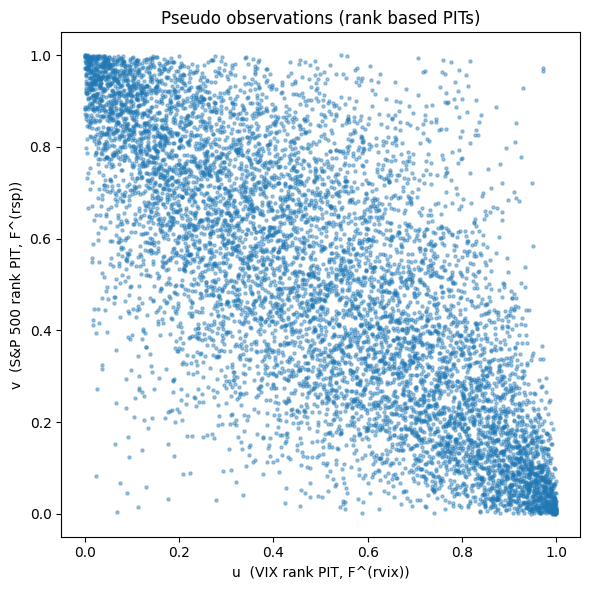

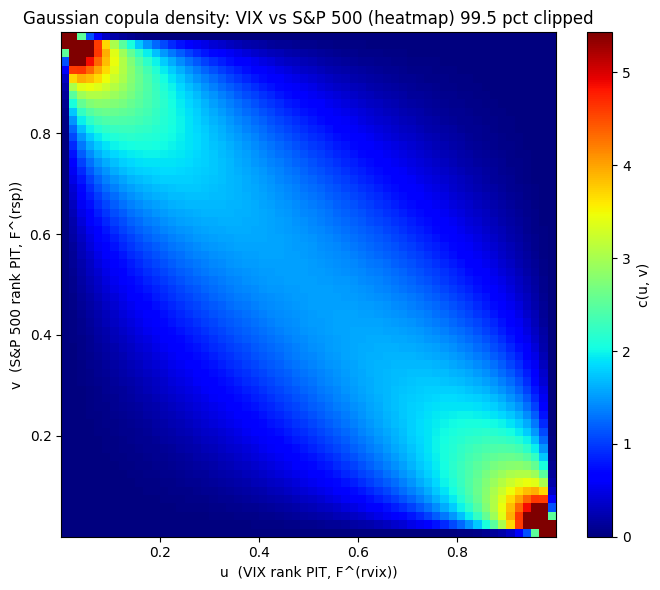

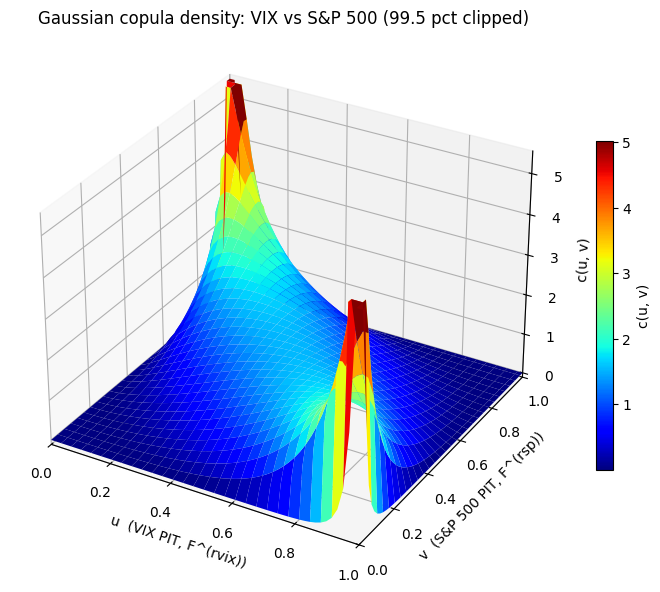

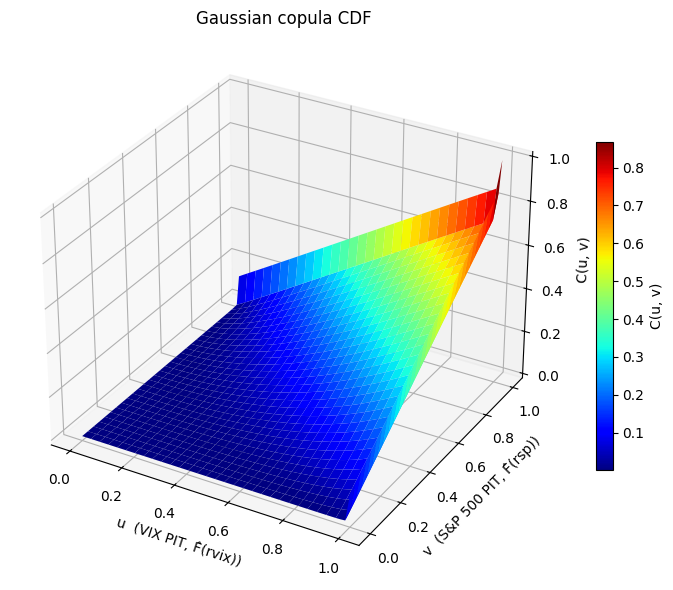

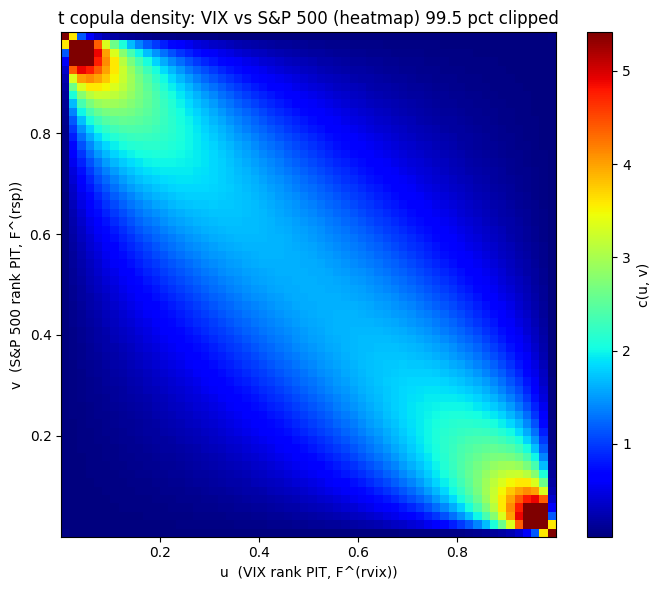

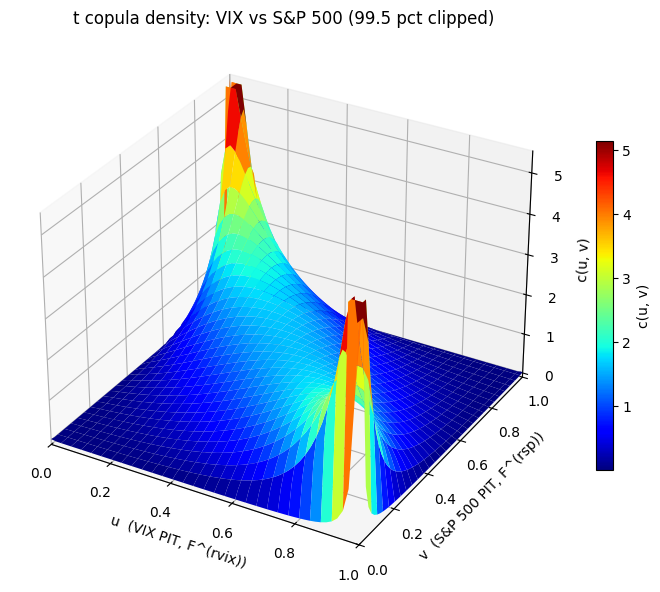

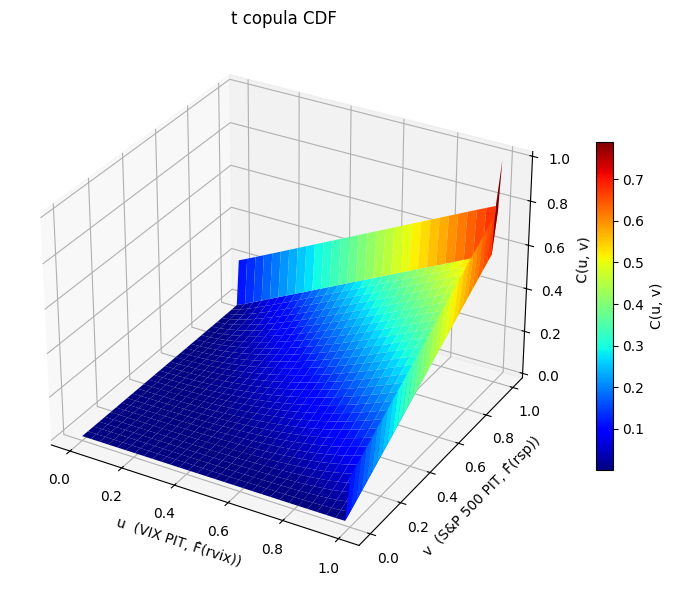

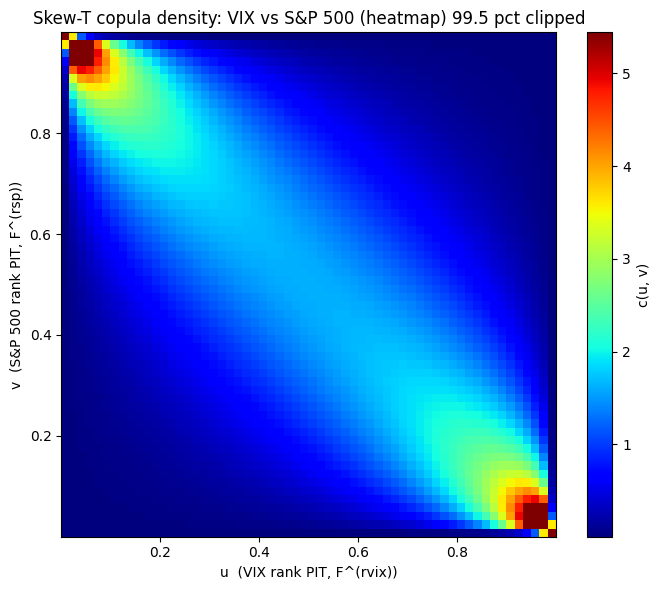

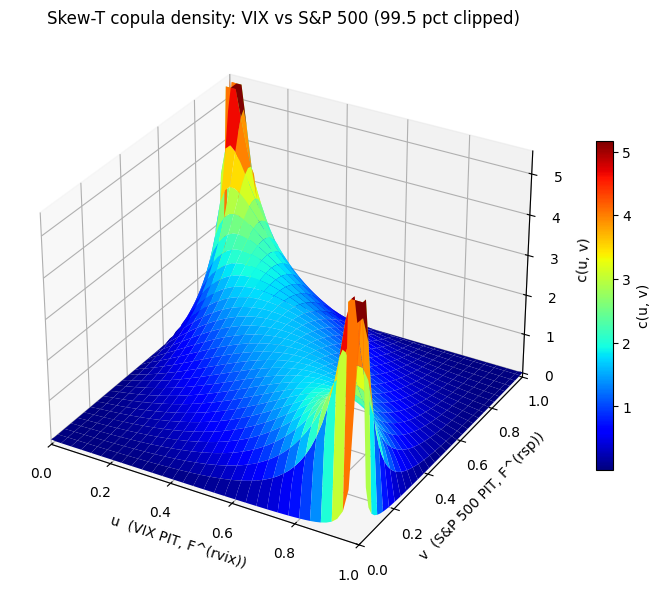

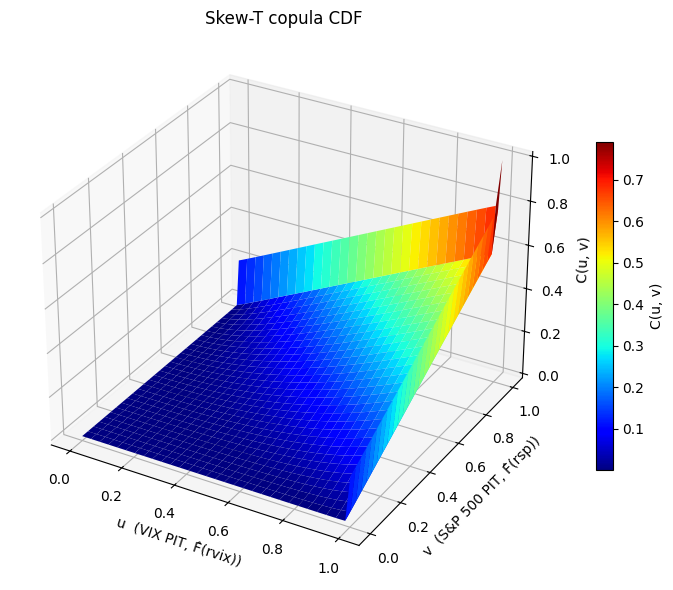

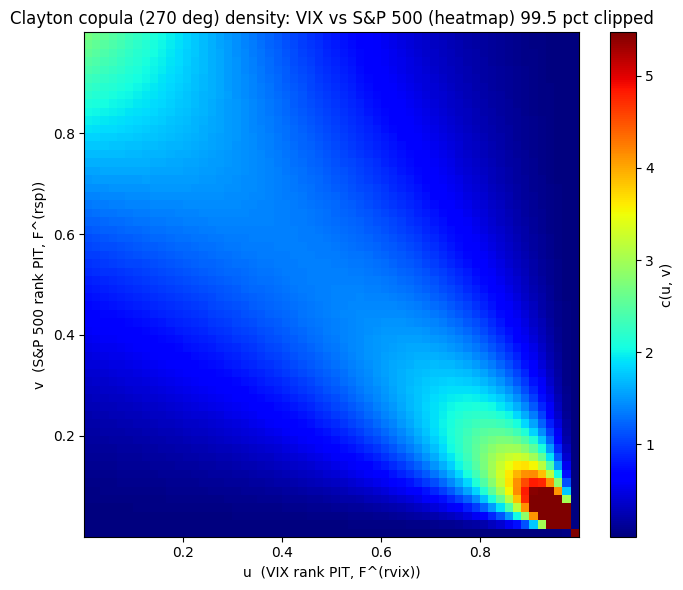

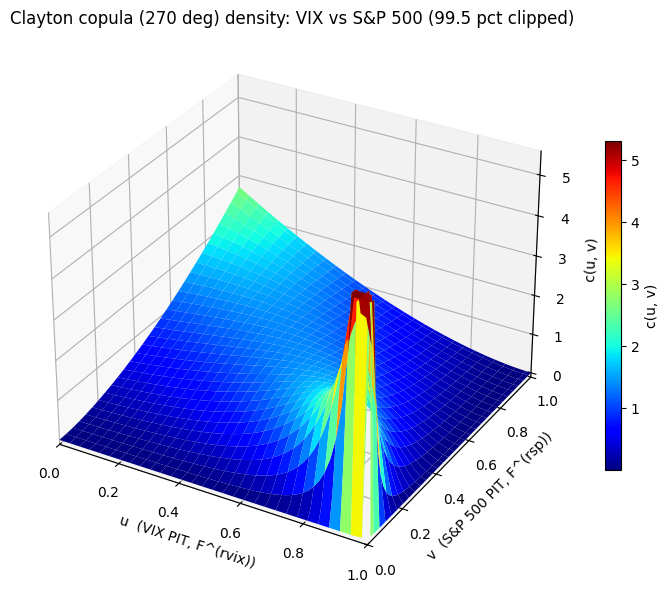

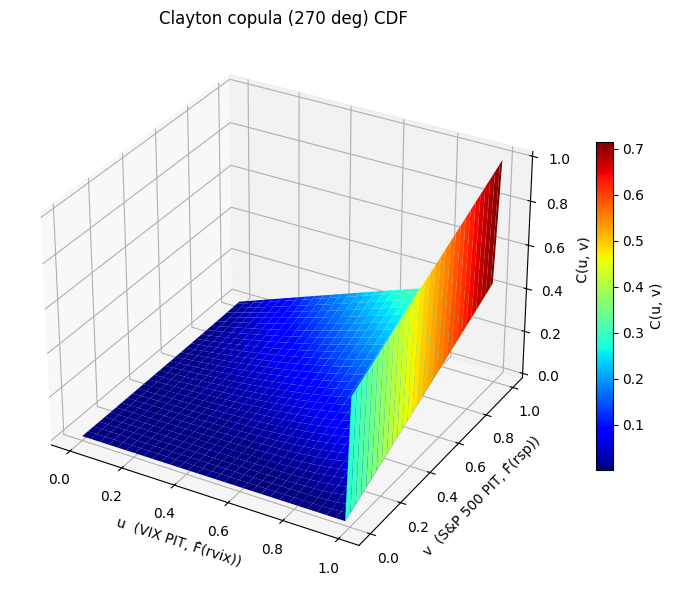

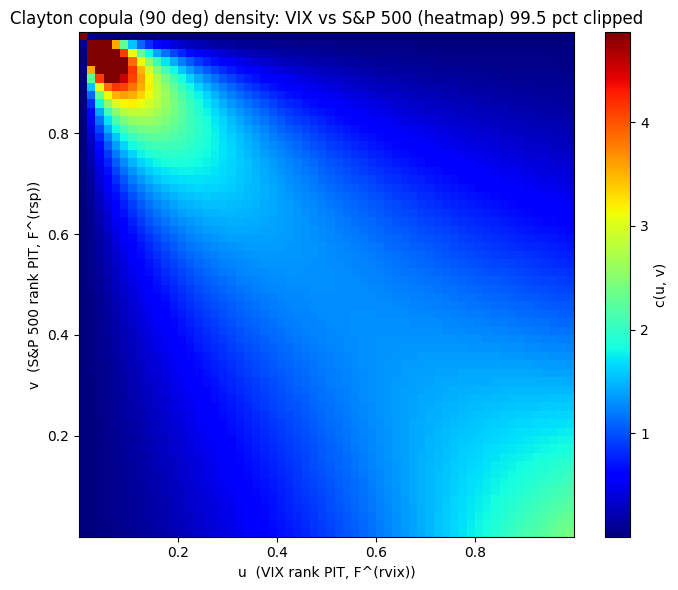

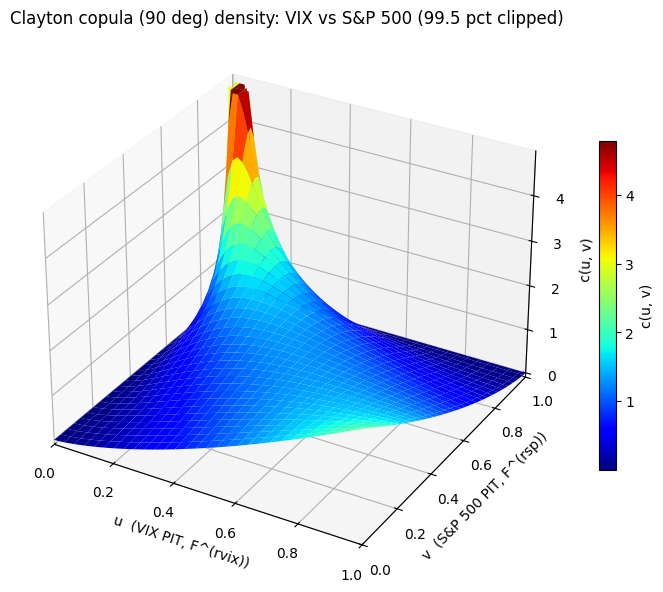

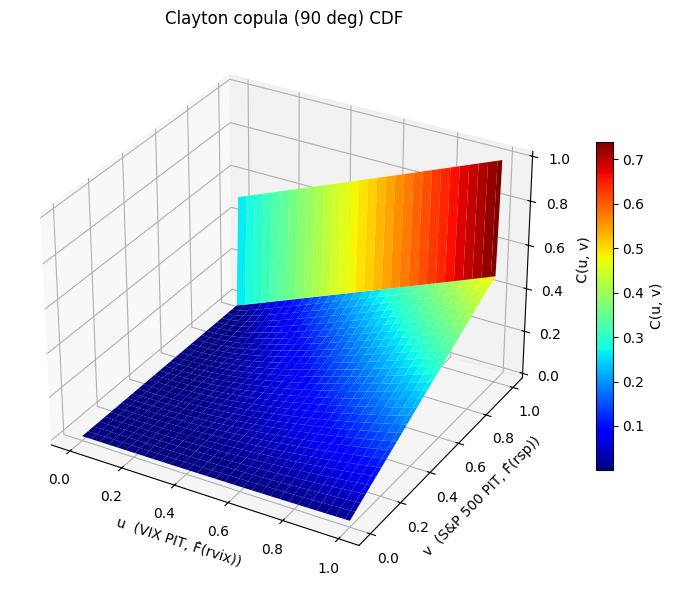

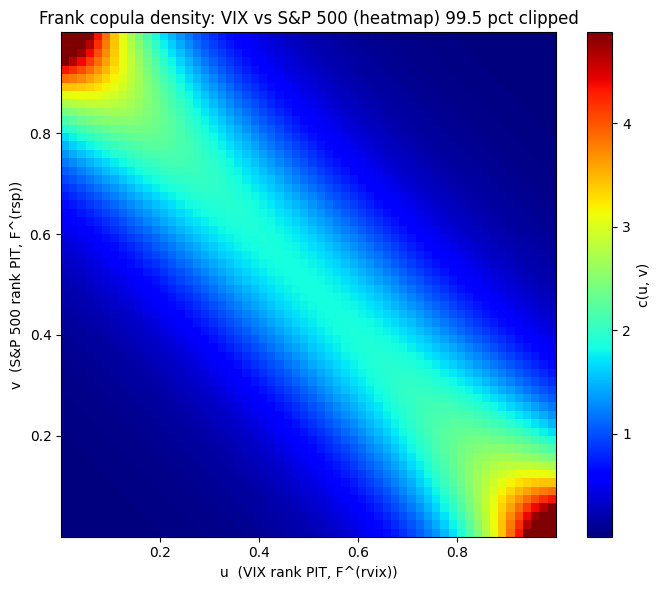

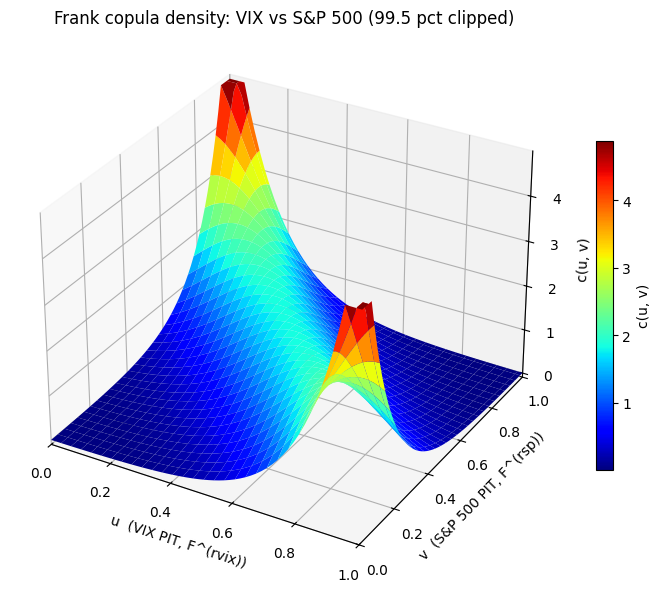

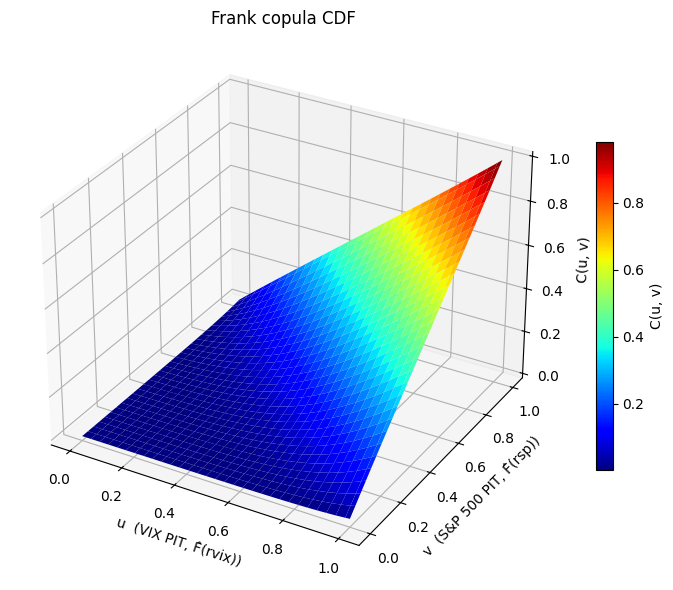

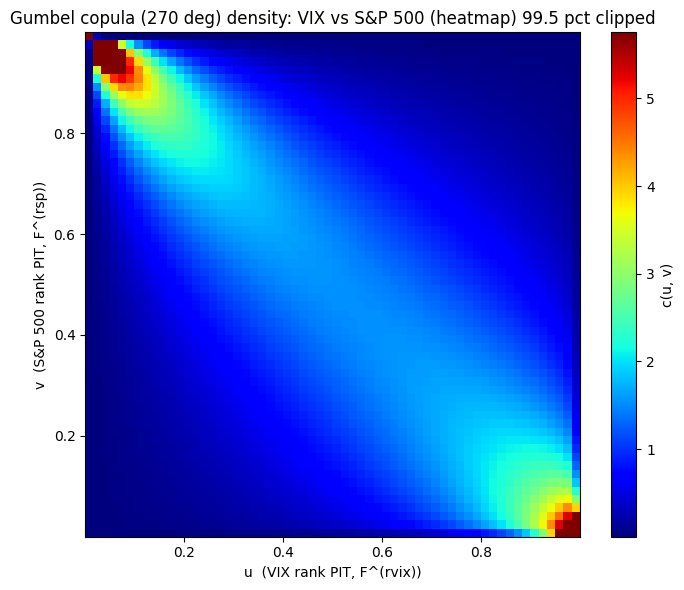

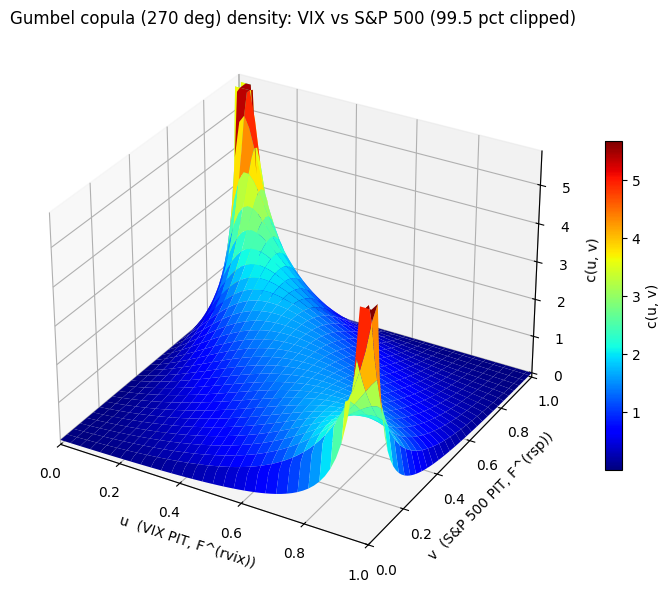

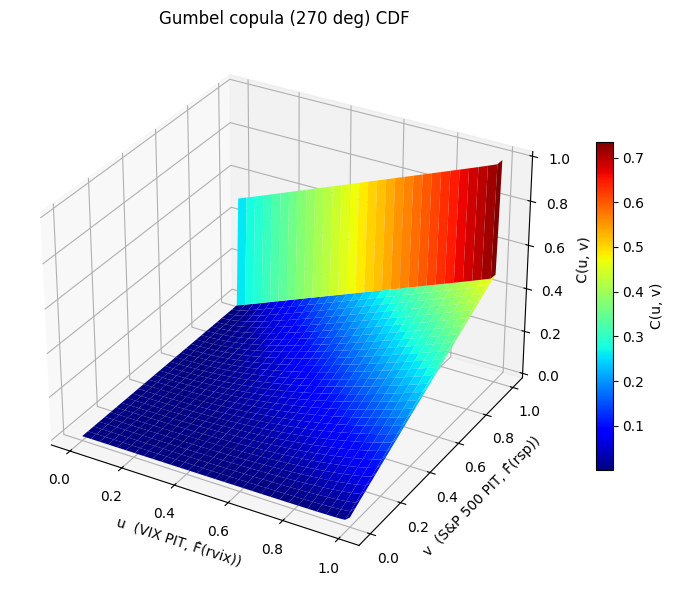

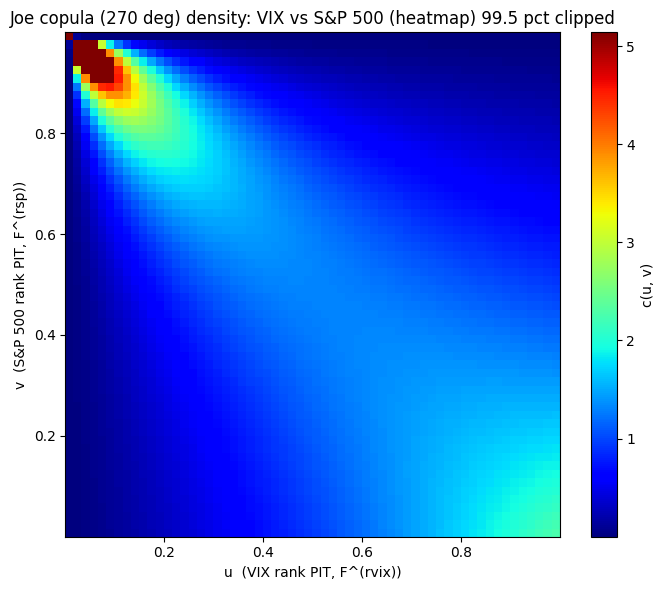

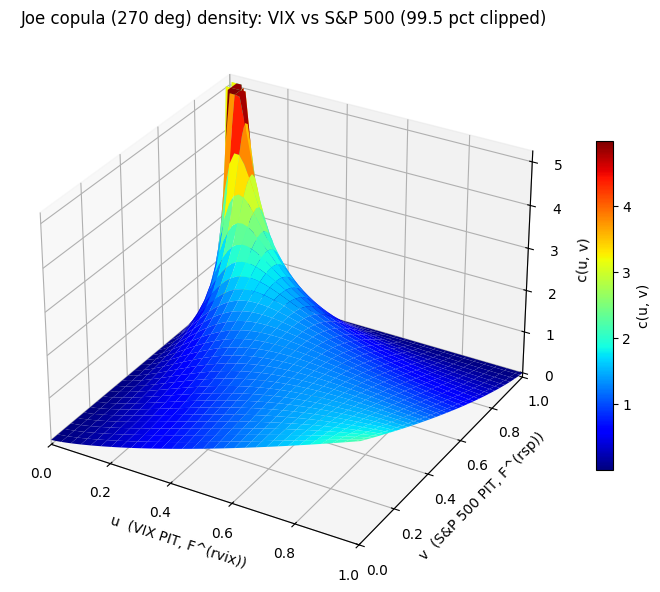

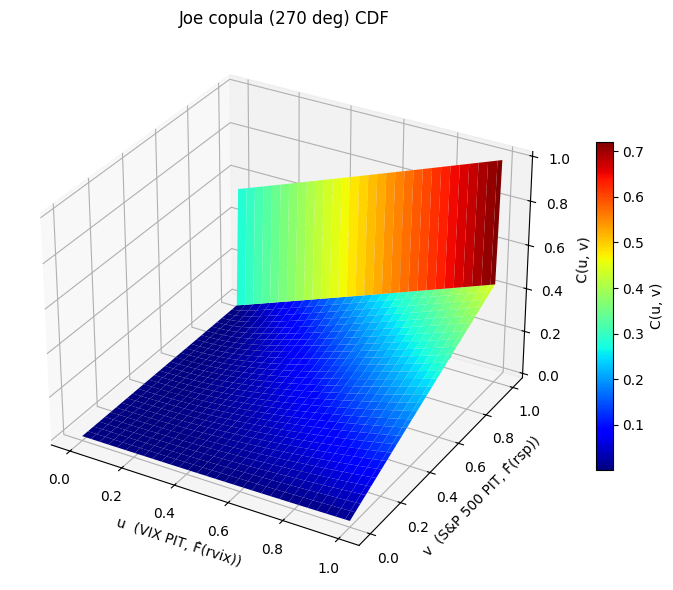

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm, t as student_t, rankdata
from scipy.stats import t
from scipy import optimize
import math
from scipy.optimize import minimize


np.random.seed(123)

# ------------------------------------------------------------
# 1. Load data
# ------------------------------------------------------------

def load_returns(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]

    if "date" not in df.columns or "rsp" not in df.columns or "rvix" not in df.columns:
        raise ValueError("CSV must have 'Date', 'rsp', 'rvix' columns.")

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df = df[["date", "rsp", "rvix"]].dropna().reset_index(drop=True)
    return df

# ------------------------------------------------------------
# 1b. Rank based pseudo observations (empirical PITs)
# ------------------------------------------------------------

def pseudo_observations(x):
    """
    Rank based pseudo observations:
    """
    x = np.asarray(x)
    n = x.shape[0]
    ranks = rankdata(x, method="average")  # 1..n
    u = ranks / (n + 1.0)
    return u

# ------------------------------------------------------------
# 2. Gaussian copula
# ------------------------------------------------------------

def gaussian_copula_loglik(rho, u, v):
    """
    Log likelihood of Gaussian copula for given rho in (-1,1).
    """
    if not (-0.999 < rho < 0.999):
        return -np.inf

    u = np.asarray(u)
    v = np.asarray(v)
    z1 = norm.ppf(u)
    z2 = norm.ppf(v)

    mask = np.isfinite(z1) & np.isfinite(z2)
    z1 = z1[mask]
    z2 = z2[mask]

    one_minus_r2 = 1.0 - rho**2
    if one_minus_r2 <= 0:
        return -np.inf

    term1 = -0.5 * np.log(one_minus_r2)
    quad = (z1**2 - 2.0 * rho * z1 * z2 + z2**2) / (2.0 * one_minus_r2)
    term2 = -quad
    term3 = 0.5 * (z1**2 + z2**2)

    log_c = term1 + term2 + term3
    return float(log_c.sum())


def fit_gaussian_copula(u, v):
    """
    Maximise Gaussian copula log likelihood over rho in (-0.999,0.999)
    using 1D bounded optimisation.
    """
    def obj(rho):
        return -gaussian_copula_loglik(rho, u, v)

    # starting value from probit correlation (not required but helpful)
    z1 = norm.ppf(u)
    z2 = norm.ppf(v)
    mask = np.isfinite(z1) & np.isfinite(z2)
    z1 = z1[mask]
    z2 = z2[mask]
    sample_rho = float(np.clip(np.corrcoef(z1, z2)[0, 1], -0.95, 0.95))

    res = optimize.minimize_scalar(
        obj,
        bounds=(-0.999, 0.999),
        method="bounded",
        options={"xatol": 1e-6}
    )
    if not res.success:
        raise RuntimeError(f"Gaussian copula optimisation failed: {res.message}")

    rho_hat = float(res.x)
    ll_hat = gaussian_copula_loglik(rho_hat, u, v)
    return rho_hat, ll_hat


def gaussian_copula_density_grid(rho, grid_size=40):
    """
    Evaluate Gaussian copula density on a grid in [0,1]^2.
    """
    grid_axis = np.linspace(1e-4, 1 - 1e-4, grid_size)
    U, V = np.meshgrid(grid_axis, grid_axis)

    z1 = norm.ppf(U)
    z2 = norm.ppf(V)

    one_minus_r2 = 1.0 - rho**2
    term1 = -0.5 * np.log(one_minus_r2)
    quad = (z1**2 - 2.0 * rho * z1 * z2 + z2**2) / (2.0 * one_minus_r2)
    term2 = -quad
    term3 = 0.5 * (z1**2 + z2**2)

    log_c = term1 + term2 + term3
    C = np.exp(log_c)
    return U, V, C

# ------------------------------------------------------------
# 3. Student t copula (2 parameters: rho, nu)
# ------------------------------------------------------------

def t_copula_loglik(u, v, rho, nu):
    """
    Log likelihood of bivariate t copula with correlation rho and df nu.
    c(u,v;rho,nu) = f_2(y1,y2; rho,nu) / [f_1(y1;nu) f_1(y2;nu)]
      where y_i = t_nu^{-1}(u_i).
    """
    if not (-0.999 < rho < 0.999) or nu <= 2:
        return -np.inf

    u = np.asarray(u)
    v = np.asarray(v)
    y1 = student_t.ppf(u, df=nu)
    y2 = student_t.ppf(v, df=nu)

    mask = np.isfinite(y1) & np.isfinite(y2)
    y1 = y1[mask]
    y2 = y2[mask]

    det = 1.0 - rho**2
    if det <= 0:
        return -np.inf

    quad = (y1**2 - 2.0 * rho * y1 * y2 + y2**2) / (nu * det)

    log_const = (
        math.lgamma((nu + 2.0) / 2.0)
        - math.lgamma(nu / 2.0)
        - 0.5 * math.log(det)
        - math.log(math.pi * nu)
    )
    log_fbiv = log_const - (nu + 2.0) / 2.0 * np.log1p(quad)

    logf1 = student_t.logpdf(y1, df=nu)
    logf2 = student_t.logpdf(y2, df=nu)

    log_c = log_fbiv - logf1 - logf2
    return float(log_c.sum())


def fit_t_copula_grid(u, v, rho_grid=None, nu_grid=None):
    """
    Coarse grid search MLE for t copula parameters (rho, nu).
    """
    if rho_grid is None:
        rho_grid = np.linspace(-0.95, 0.95, 41)
    if nu_grid is None:
        nu_grid = np.linspace(4.0, 30.0, 27)

    best_ll = -np.inf
    best_rho = None
    best_nu = None

    for rho in rho_grid:
        for nu in nu_grid:
            ll = t_copula_loglik(u, v, rho, nu)
            if ll > best_ll:
                best_ll = ll
                best_rho = rho
                best_nu = nu

    if best_rho is None:
        raise RuntimeError("t copula grid search failed to find finite likelihood.")

    return best_rho, best_nu, best_ll


def t_copula_density_grid(rho, nu, grid_size=40):
    """
    Evaluate t copula density on a grid in [0,1]^2.
    """
    grid_axis = np.linspace(1e-4, 1 - 1e-4, grid_size)
    U, V = np.meshgrid(grid_axis, grid_axis)  # use grid_axis twice

    y1 = student_t.ppf(U, df=nu)
    y2 = student_t.ppf(V, df=nu)

    det = 1.0 - rho**2
    const = math.gamma((nu + 2.0) / 2.0) / (
        math.gamma(nu / 2.0) * nu * math.pi * math.sqrt(det)
    )
    quad = (y1**2 - 2.0 * rho * y1 * y2 + y2**2) / (nu * det)
    f_biv = const * (1.0 + quad) ** (-(nu + 2.0) / 2.0)

    f1 = student_t.pdf(y1, df=nu)
    f2 = student_t.pdf(y2, df=nu)

    C = f_biv / (f1 * f2)
    return U, V, C



# ------------------------------------------------------------
# 4. Clayton copula (Archimedean) and rotations
# ------------------------------------------------------------

def clayton_loglik_theta(u, v, theta):
    """
    Log likelihood for standard Clayton copula, theta > 0:
    """
    if theta <= 0:
        return -np.inf

    u = np.asarray(u)
    v = np.asarray(v)

    if np.any(u <= 0) or np.any(v <= 0) or np.any(u >= 1) or np.any(v >= 1):
        return -np.inf

    log_u = np.log(u)
    log_v = np.log(v)
    log_uv = log_u + log_v

    s = u**(-theta) + v**(-theta) - 1.0
    if np.any(s <= 0):
        return -np.inf

    log_s = np.log(s)

    ll = (
        np.log(theta + 1.0)
        + (-theta - 1.0) * log_uv
        + (-1.0 / theta - 2.0) * log_s
    )
    return float(ll.sum())


def fit_clayton_copula(u, v):
    """
    Fit standard (lower lower) Clayton via 1D optimisation over log(theta).
    """
    def obj(alpha):
        theta = math.exp(alpha)  # theta > 0
        ll = clayton_loglik_theta(u, v, theta)
        return -ll

    res = optimize.minimize_scalar(obj, bounds=(-5.0, 5.0), method="bounded")
    if not res.success:
        raise RuntimeError("Clayton optimisation failed: " + res.message)

    theta_hat = math.exp(res.x)
    ll_hat = clayton_loglik_theta(u, v, theta_hat)
    return theta_hat, ll_hat


def clayton_copula_density_grid(theta, grid_size=40):
    """
    Standard Clayton density on a [0,1]^2 grid (lower lower tail dependence).
    """
    grid_axis = np.linspace(1e-4, 1 - 1e-4, grid_size)
    U, V = np.meshgrid(grid_axis, grid_axis)

    s = U**(-theta) + V**(-theta) - 1.0
    C = (theta + 1.0) * (U * V)**(-theta - 1.0) * s**(-1.0 / theta - 2.0)
    return U, V, C


# 270 degree rotation (used earlier)
def fit_clayton_copula_rot270(u, v):
    u_rot = 1.0 - np.asarray(u)
    v_rot = np.asarray(v)
    theta_hat, ll_hat = fit_clayton_copula(u_rot, v_rot)
    return theta_hat, ll_hat


def clayton_copula_density_grid_rot270(theta, grid_size=40):
    grid_axis = np.linspace(1e-4, 1 - 1e-4, grid_size)
    U, V = np.meshgrid(grid_axis, grid_axis)

    U_base = 1.0 - U
    V_base = V

    s = U_base**(-theta) + V_base**(-theta) - 1.0
    C_rot = (theta + 1.0) * (U_base * V_base)**(-theta - 1.0) * s**(-1.0 / theta - 2.0)
    return U, V, C_rot


# 90 degree rotation: transform v -> 1 - v
def fit_clayton_copula_rot90(u, v):
    u_rot = np.asarray(u)
    v_rot = 1.0 - np.asarray(v)
    theta_hat, ll_hat = fit_clayton_copula(u_rot, v_rot)
    return theta_hat, ll_hat


def clayton_copula_density_grid_rot90(theta, grid_size=40):
    grid_axis = np.linspace(1e-4, 1 - 1e-4, grid_size)
    U, V = np.meshgrid(grid_axis, grid_axis)

    U_base = U
    V_base = 1.0 - V

    s = U_base**(-theta) + V_base**(-theta) - 1.0
    C_rot = (theta + 1.0) * (U_base * V_base)**(-theta - 1.0) * s**(-1.0 / theta - 2.0)
    return U, V, C_rot

# ==== Copula CDFs for Archimedean families and their rotations ====

def clayton_C_base(u, v, theta):
    u = np.asarray(u)
    v = np.asarray(v)
    return (u**(-theta) + v**(-theta) - 1.0)**(-1.0 / theta)

def clayton_C_rot270(u, v, theta):
    # rotation based on (1-u, v)
    return v - clayton_C_base(1.0 - u, v, theta)

def clayton_C_rot90(u, v, theta):
    # rotation based on (u, 1-v)
    return u - clayton_C_base(u, 1.0 - v, theta)


def frank_C_base(u, v, theta):
    """
    Frank copula CDF
    """
    u = np.asarray(u)
    v = np.asarray(v)

    if theta == 0.0:
        # independence
        return u * v

    et = math.exp(-theta)
    num = (np.exp(-theta * u) - 1.0) * (np.exp(-theta * v) - 1.0)
    den = et - 1.0

    A = 1.0 + num / den
    A = np.clip(A, 1e-15, None)

    return -(1.0 / theta) * np.log(A)


def gumbel_C_base(u, v, theta):
    u = np.asarray(u)
    v = np.asarray(v)
    x = (-np.log(u))**theta
    y = (-np.log(v))**theta
    s = x + y
    return np.exp(-s**(1.0 / theta))

def gumbel_C_rot270(u, v, theta):
    # rotation based on (1-u, v)
    return v - gumbel_C_base(1.0 - u, v, theta)


def joe_C_base(u, v, theta):
    u = np.asarray(u)
    v = np.asarray(v)
    t1 = (1.0 - u)**theta
    t2 = (1.0 - v)**theta
    s = t1 + t2 - t1 * t2
    s = np.clip(s, 0.0, None)
    return 1.0 - s**(1.0 / theta)

def joe_C_rot270(u, v, theta):
    # rotation based on (1-u, v)
    return v - joe_C_base(1.0 - u, v, theta)

# ------------------------------------------------------------
# 5. Frank copula (one parameter, can be positive or negative)
# ------------------------------------------------------------

def frank_loglik_theta(u, v, theta):
    """
    Log-likelihood for the Frank copula using the exact density formula.
    """
    u = np.asarray(u)
    v = np.asarray(v)

    if theta == 0.0:
        # independence: c(u,v) = 1 -> log-likelihood = 0
        return 0.0

    et = np.exp(theta)

    num = theta * (et - 1.0) * np.exp(theta * (u + v + 1.0))
    den = (
        et
        - np.exp(theta * (u + 1.0))
        + np.exp(theta * (u + v))
        - np.exp(theta * (v + 1.0))
    ) ** 2

    den = np.clip(den, 1e-300, None)
    c = num / den

    if np.any(c <= 0) or np.any(~np.isfinite(c)):
        return -np.inf

    return float(np.log(c).sum())


def fit_frank_copula(u, v):
    """
    Fit Frank copula by maximising the log-likelihood over theta directly.
    """
    def obj(theta):
        return -frank_loglik_theta(u, v, theta)
    
    res = optimize.minimize_scalar(obj, bounds=(-10.0, 10.0), method="bounded")
    if not res.success:
        raise RuntimeError("Frank optimisation failed: " + res.message)

    theta_hat = float(res.x)
    ll_hat = frank_loglik_theta(u, v, theta_hat)
    return theta_hat, ll_hat


def frank_copula_density_grid(theta, grid_size=40):
    """
    Frank copula density c(u,v) on a [0,1]^2 grid.
    """
    grid_axis = np.linspace(1e-4, 1.0 - 1e-4, grid_size)
    U, V = np.meshgrid(grid_axis, grid_axis)

    if theta == 0.0:
        # independence: density is 1 everywhere
        return U, V, np.ones_like(U)

    et = np.exp(theta)
    num = theta * (et - 1.0) * np.exp(theta * (U + V + 1.0))
    den = (
        et
        - np.exp(theta * (U + 1.0))
        + np.exp(theta * (U + V))
        - np.exp(theta * (V + 1.0))
    ) ** 2

    den = np.clip(den, 1e-300, None)
    C = num / den
    return U, V, C



# ------------------------------------------------------------
# 6. Gumbel copula, 270 degree rotation
# ------------------------------------------------------------

def gumbel_loglik_theta(u, v, theta):
    """
    Standard Gumbel copula, theta >= 1.
    """
    if theta < 1.0:
        return -np.inf

    u = np.asarray(u)
    v = np.asarray(v)

    if np.any((u <= 0) | (u >= 1) | (v <= 0) | (v >= 1)):
        return -np.inf

    x = -np.log(u)
    y = -np.log(v)
    x_t = x**theta
    y_t = y**theta
    s = x_t + y_t
    s1 = s**(1.0 / theta)

    C = np.exp(-s1)

    part1 = C / (u * v)
    part2 = (x * y)**(theta - 1.0)
    part3 = s**(1.0 / theta - 2.0)
    part4 = theta - 1.0 + s1

    c = part1 * part2 * part3 * part4
    if np.any(c <= 0):
        return -np.inf

    return float(np.log(c).sum())


def fit_gumbel_copula_rot270(u, v):
    """
    Fit 270 degree rotated Gumbel by fitting standard Gumbel on (1-u, v).
    """
    u_rot = 1.0 - np.asarray(u)
    v_rot = np.asarray(v)

    def obj(alpha):
        theta = 1.0 + math.exp(alpha)  # theta >= 1
        return -gumbel_loglik_theta(u_rot, v_rot, theta)

    res = optimize.minimize_scalar(obj, bounds=(-5.0, 5.0), method="bounded")
    if not res.success:
        raise RuntimeError("Gumbel optimisation failed: " + res.message)

    theta_hat = 1.0 + math.exp(res.x)
    ll_hat = gumbel_loglik_theta(u_rot, v_rot, theta_hat)
    return theta_hat, ll_hat


def gumbel_copula_density_grid_rot270(theta, grid_size=40):
    """
    270 degree rotated Gumbel: base variables are (1-U, V).
    """
    grid_axis = np.linspace(1e-4, 1 - 1e-4, grid_size)
    U, V = np.meshgrid(grid_axis, grid_axis)

    U_base = 1.0 - U
    V_base = V

    x = -np.log(U_base)
    y = -np.log(V_base)
    x_t = x**theta
    y_t = y**theta
    s = x_t + y_t
    s1 = s**(1.0 / theta)

    C_base = np.exp(-s1)

    part1 = C_base / (U_base * V_base)
    part2 = (x * y)**(theta - 1.0)
    part3 = s**(1.0 / theta - 2.0)
    part4 = theta - 1.0 + s1

    C_rot = part1 * part2 * part3 * part4
    return U, V, C_rot

# ------------------------------------------------------------
# 7. Joe copula, 270 degree rotation
# ------------------------------------------------------------

def joe_loglik_theta(u, v, theta):
    """
    Standard Joe copula, theta >= 1
    """
    if theta < 1.0:
        return -np.inf

    u = np.asarray(u)
    v = np.asarray(v)

    if np.any((u <= 0) | (u >= 1) | (v <= 0) | (v >= 1)):
        return -np.inf

    t1 = (1.0 - u)**theta
    t2 = (1.0 - v)**theta
    s = t1 + t2 - t1 * t2

    if np.any(s <= 0):
        return -np.inf

    s_pow = s**(1.0 / theta - 2.0)
    factor = theta - 1.0 + s
    c = s_pow * factor * (1.0 - u)**(theta - 1.0) * (1.0 - v)**(theta - 1.0)
    if np.any(c <= 0):
        return -np.inf

    return float(np.log(c).sum())


def fit_joe_copula_rot270(u, v):
    """
    Fit 270 degree rotated Joe by fitting standard Joe on (1-u, v).
    """
    u_rot = 1.0 - np.asarray(u)
    v_rot = np.asarray(v)

    def obj(alpha):
        theta = 1.0 + math.exp(alpha)
        return -joe_loglik_theta(u_rot, v_rot, theta)

    res = optimize.minimize_scalar(obj, bounds=(-5.0, 5.0), method="bounded")
    if not res.success:
        raise RuntimeError("Joe optimisation failed: " + res.message)

    theta_hat = 1.0 + math.exp(res.x)
    ll_hat = joe_loglik_theta(u_rot, v_rot, theta_hat)
    return theta_hat, ll_hat


def joe_copula_density_grid_rot270(theta, grid_size=40):
    grid_axis = np.linspace(1e-4, 1 - 1e-4, grid_size)
    U, V = np.meshgrid(grid_axis, grid_axis)

    U_base = 1.0 - U
    V_base = V

    t1 = (1.0 - U_base)**theta
    t2 = (1.0 - V_base)**theta
    s = t1 + t2 - t1 * t2

    s_pow = s**(1.0 / theta - 2.0)
    factor = theta - 1.0 + s
    C_rot = s_pow * factor * (1.0 - U_base)**(theta - 1.0) * (1.0 - V_base)**(theta - 1.0)
    return U, V, C_rot


# ---------------
# Skew t
# ---------------
def skew_t_copula_loglik(params, u, v):
    rho, nu, alpha = params

    # parameter constraints
    if not (-0.999 < rho < 0.999) or nu <= 2 or alpha < 0:
        return np.inf

    u = np.asarray(u)
    v = np.asarray(v)

    # transform uniforms to skew-t quantiles
    y1 = skew_t_ppf(u, nu, alpha)
    y2 = skew_t_ppf(v, nu, alpha)

    det = 1.0 - rho**2
    if det <= 0:
        return np.inf

    # quadratic form
    quad = (y1**2 - 2.0 * rho * y1 * y2 + y2**2) / (nu * det)

    log_const = (
        math.lgamma((nu + 2.0) / 2.0)
        - math.lgamma(nu / 2.0)
        - 0.5 * math.log(det)
        - math.log(math.pi * nu)
    )

    log_fbiv = log_const - (nu + 2.0) / 2.0 * np.log1p(quad)

    # marginal log-densities
    logf1 = np.log(skew_t_pdf(y1, nu, alpha))
    logf2 = np.log(skew_t_pdf(y2, nu, alpha))

    # copula log-density
    log_c = log_fbiv - logf1 - logf2

    # negative log-likelihood
    return -np.sum(log_c)

# Function to fit the Skew-T copula using MLE
def fit_skew_t_copula_mle(u, v, initial_guess=None):
    if initial_guess is None:
        initial_guess = [0.0, 10.0, 0.0]

    bounds = [(-0.99, 0.99), (2.01, 50.0), (0.0, 0.99)]

    result = minimize(
        skew_t_copula_loglik,
        initial_guess,
        args=(u, v),
        bounds=bounds,
        method='L-BFGS-B'   
    )

    if not result.success:
        raise RuntimeError("MLE optimization failed: " + result.message)

    rho_hat, nu_hat, alpha_hat = result.x
    loglik_hat = -result.fun

    return rho_hat, nu_hat, alpha_hat, loglik_hat

# Skew-T Copula Inverse CDF (PPF)
def skew_t_ppf(u, nu, alpha):
    """
    Compute the inverse CDF (quantile function) for the Skew-T distribution.
    """
    z = t.ppf(u, df=nu)  # Standard t-distribution quantile
    return z + alpha * np.abs(z)  # Apply skew transformation

# Skew-T Copula PDF
def skew_t_pdf(x, nu, alpha):
    """
    "Skewed" t pdf (ad-hoc): base t.pdf times a skew factor.
    """
    x = np.asarray(x)
    base = t.pdf(x, df=nu)

    sign_x = np.sign(x)
    skew_factor = 1.0 + alpha * sign_x

    skew_factor = np.clip(skew_factor, 1e-8, None)

    return base * skew_factor

# Skew-T Copula Density Grid (for plotting)
def skew_t_copula_density_grid(rho, nu, alpha, grid_size=60):
    grid_axis = np.linspace(1e-4, 1 - 1e-4, grid_size)
    U, V = np.meshgrid(grid_axis, grid_axis)

    y1 = skew_t_ppf(U, nu, alpha)
    y2 = skew_t_ppf(V, nu, alpha)

    det = 1.0 - rho**2
    quad = (y1**2 - 2.0 * rho * y1 * y2 + y2**2) / (nu * det)

    log_const = (
        math.lgamma((nu + 2.0) / 2.0)
        - math.lgamma(nu / 2.0)
        - 0.5 * math.log(det)
        - math.log(math.pi * nu)
    )
    log_fbiv = log_const - (nu + 2.0) / 2.0 * np.log1p(quad)
    f_biv = np.exp(log_fbiv)

    f1 = skew_t_pdf(y1, nu, alpha)
    f2 = skew_t_pdf(y2, nu, alpha)

    # copula density = joint / (marginals)
    C = f_biv / (f1 * f2)

    return U, V, C


# ------------------------------------------------------------
# 8. Metrics: AIC/BIC, tail dependence, joint probabilities
# ------------------------------------------------------------

def compute_aic_bic(loglik, k, n_obs):
    aic = 2 * k - 2 * loglik
    bic = k * np.log(n_obs) - 2 * loglik
    return aic, bic

def tail_indices_empirical(u, v, alphas):
    """
    Empirical tail indices
    """
    u = np.asarray(u)
    v = np.asarray(v)
    out = {}
    for a in alphas:
        mask1 = v > 1.0 - a
        mask2 = v < a

        if mask1.sum() > 0:
            tdi1 = np.mean(u[mask1] < a)
        else:
            tdi1 = np.nan

        if mask2.sum() > 0:
            tdi2 = np.mean(u[mask2] > 1.0 - a)
        else:
            tdi2 = np.nan

        out[a] = (tdi1, tdi2)
    return out

def joint_crash_probs_empirical(u, v, alphas):
    """
    Empirical joint crash probabilities
    """
    u = np.asarray(u)
    v = np.asarray(v)
    out = {}
    for a in alphas:
        jp = np.mean((u < a) & (v > 1.0 - a))
        out[a] = jp
    return out

# ------------------------------------------------------------
# 9. Simulation from copulas (for tail metrics, limited families)
# ------------------------------------------------------------

def simulate_gaussian_copula(rho, n_sim):
    cov = np.array([[1.0, rho],
                    [rho, 1.0]])
    z = np.random.multivariate_normal(mean=[0.0, 0.0], cov=cov, size=n_sim)
    u_sim = norm.cdf(z[:, 0])
    v_sim = norm.cdf(z[:, 1])
    return u_sim, v_sim

def simulate_t_copula(rho, nu, n_sim):
    cov = np.array([[1.0, rho],
                    [rho, 1.0]])
    z = np.random.multivariate_normal(mean=[0.0, 0.0], cov=cov, size=n_sim)
    w = np.random.chisquare(df=nu, size=n_sim)
    y = z / np.sqrt(w[:, None] / nu)
    u_sim = student_t.cdf(y[:, 0], df=nu)
    v_sim = student_t.cdf(y[:, 1], df=nu)
    return u_sim, v_sim


def model_tail_indices_and_joint_probs(family, params, alphas, n_sim=200000):
    """
    For Gaussian and t: simulate and compute tail indices / joint probs (Monte Carlo).
    For Clayton rotations, Frank, Gumbel270, Joe270: compute them analytically via C(u,v).

    """
    # 1) Families where we do Monte Carlo simulation
    if family == "gaussian":
        rho = params["rho"]
        u_sim, v_sim = simulate_gaussian_copula(rho, n_sim)
        tdi = tail_indices_empirical(u_sim, v_sim, alphas)
        jp = joint_crash_probs_empirical(u_sim, v_sim, alphas)
        return tdi, jp

    if family == "t":
        rho = params["rho"]
        nu = params["nu"]
        u_sim, v_sim = simulate_t_copula(rho, nu, n_sim)
        tdi = tail_indices_empirical(u_sim, v_sim, alphas)
        jp = joint_crash_probs_empirical(u_sim, v_sim, alphas)
        return tdi, jp
    

    if family == "skew_t":
        rho = params["rho"]
        nu = params["nu"]
        alpha = params["alpha"]
        # approximate using t-copula simulation (since alpha is essentially 0 anyway)
        u_sim, v_sim = simulate_t_copula(rho, nu, n_sim)
        tdi = tail_indices_empirical(u_sim, v_sim, alphas)
        jp = joint_crash_probs_empirical(u_sim, v_sim, alphas)
        return tdi, jp

    # 2) Families where we use analytic formulas via the copula CDF
    tdi = {}
    jp = {}

    for a in alphas:
        if family == "clayton270":
            theta = params["theta"]
            C_a_1ma = clayton_C_rot270(a, 1.0 - a, theta)
            C_1ma_a = clayton_C_rot270(1.0 - a, a, theta)

        elif family == "clayton90":
            theta = params["theta"]
            C_a_1ma = clayton_C_rot90(a, 1.0 - a, theta)
            C_1ma_a = clayton_C_rot90(1.0 - a, a, theta)

        elif family == "frank":
            theta = params["theta"]
            C_a_1ma = frank_C_base(a, 1.0 - a, theta)
            C_1ma_a = frank_C_base(1.0 - a, a, theta)

        elif family == "gumbel270":
            theta = params["theta"]
            C_a_1ma = gumbel_C_rot270(a, 1.0 - a, theta)
            C_1ma_a = gumbel_C_rot270(1.0 - a, a, theta)

        elif family == "joe270":
            theta = params["theta"]
            C_a_1ma = joe_C_rot270(a, 1.0 - a, theta)
            C_1ma_a = joe_C_rot270(1.0 - a, a, theta)

        else:
            # unknown family: return NaNs
            tdi[a] = (np.nan, np.nan)
            jp[a] = np.nan
            continue

        jp_a = a - C_a_1ma

        tdi1 = 1.0 - C_a_1ma / a

        tdi2 = 1.0 - C_1ma_a / a

        jp[a] = float(jp_a)
        tdi[a] = (float(tdi1), float(tdi2))

    return tdi, jp

# ------------------------------------------------------------
# 10. Plotting helpers
# ------------------------------------------------------------

def plot_copula_heatmap(U, V, C, title_prefix="Copula",
                        log_scale=False, clip_pct=99.0):
    """
    Heatmap for copula *density* c(u,v).
    """
    D = np.array(C, copy=True)

    # clip extremely large values so the interior is visible
    vmax = np.percentile(D, clip_pct)
    D = np.minimum(D, vmax)

    if log_scale:
        # avoid log(0)
        eps = 1e-8
        D_plot = np.log10(D + eps)
        cb_label = "log10 c(u, v)"
    else:
        D_plot = D
        cb_label = "c(u, v)"

    plt.figure(figsize=(7, 6))
    img = plt.imshow(
        D_plot,
        origin="lower",
        extent=[U.min(), U.max(), V.min(), V.max()],
        aspect="auto",
        cmap="jet"
    )
    plt.colorbar(img, label=cb_label)
    plt.xlabel("u  (VIX rank PIT, F^(rvix))")
    plt.ylabel("v  (S&P 500 rank PIT, F^(rsp))")
    plt.title(f"{title_prefix} density: VIX vs S&P 500 (heatmap) 99.5 pct clipped")
    plt.tight_layout()


def plot_copula_surface(U, V, C, title_prefix="Copula",
                        log_scale=False, clip_pct=99.0):
    """
    3D surface for copula *density* c(u,v).
    """
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    D = np.array(C, copy=True)

    # clip extremely large values
    vmax = np.percentile(D, clip_pct)
    D = np.minimum(D, vmax)

    if log_scale:
        eps = 1e-8
        Z = np.log10(D + eps)
        cb_label = "log10 c(u, v)"
        zlabel   = "log10 c(u, v)"
    else:
        Z = D
        cb_label = "c(u, v)"
        zlabel   = "c(u, v)"

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(
        U,
        V,
        Z,
        linewidth=0,
        antialiased=True,
        cmap="jet"
    )

    fig.colorbar(surf, ax=ax, shrink=0.6, label=cb_label)

    ax.set_xlabel("u  (VIX PIT, F^(rvix))")
    ax.set_ylabel("v  (S&P 500 PIT, F^(rsp))")
    ax.set_zlabel(zlabel)
    ax.set_title(f"{title_prefix} density: VIX vs S&P 500 (99.5 pct clipped)")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.view_init(elev=30, azim=-60)

    plt.tight_layout()

def plot_pseudo_scatter(u, v):
    plt.figure(figsize=(6, 6))
    plt.scatter(u, v, s=5, alpha=0.4)
    plt.xlabel("u  (VIX rank PIT, F^(rvix))")
    plt.ylabel("v  (S&P 500 rank PIT, F^(rsp))")
    plt.title("Pseudo observations (rank based PITs)")
    plt.tight_layout()

def compute_cdf_from_density(U, V, C):
    """
    Approximate joint CDF C(u,v) from a density grid c(u,v).
    """
    # grid step sizes
    du = U[0, 1] - U[0, 0]
    dv = V[1, 0] - V[0, 0]

    F = np.cumsum(np.cumsum(C, axis=0), axis=1) * du * dv

    F = F / F.max()
    F = np.clip(F, 0.0, 1.0)
    return F


def plot_copula_cdf_surface(U, V, C, title_prefix="Copula"):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    F = compute_cdf_from_density(U, V, C)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(
        U,
        V,
        F,
        linewidth=0,
        antialiased=True,
        cmap="jet"
    )

    fig.colorbar(surf, ax=ax, shrink=0.6, label="C(u, v)")

    ax.set_xlabel("u  (VIX PIT, F̂(rvix))")
    ax.set_ylabel("v  (S&P 500 PIT, F̂(rsp))")
    ax.set_zlabel("C(u, v)")
    ax.set_title(f"{title_prefix} CDF")
    plt.tight_layout()

# ------------------------------------------------------------
# 11. Main: run all copulas and collect metrics
# ------------------------------------------------------------

def main():
    df = load_returns("sp500_vix_returns.csv")
    rsp = df["rsp"].to_numpy()
    rvix = df["rvix"].to_numpy()

    # Rank based pseudo observations
    u = pseudo_observations(rvix)  # VIX PIT
    v = pseudo_observations(rsp)   # S&P 500 PIT

    # print('output u to debug',u[:10])
    # print('output v to debug', v[:10])

    T = len(u)
    alphas = [0.05, 0.01]

    # Empirical tail indices and joint crash probabilities
    tdi_emp = tail_indices_empirical(u, v, alphas)
    jp_emp = joint_crash_probs_empirical(u, v, alphas)

    plot_pseudo_scatter(u, v)

    families = [
        "gaussian",
        "t",
        "skew_t",  # Added Skew-T copula
        "clayton270",
        "clayton90",
        "frank",
        "gumbel270",
        "joe270",
    ]

    metrics_rows = []

    for family in families:
        if family == "gaussian":
            rho_hat, ll_hat = fit_gaussian_copula(u, v)
            aic, bic = compute_aic_bic(ll_hat, k=1, n_obs=T)
            print(f"Gaussian copula: rho_hat = {rho_hat:.4f}")
            print(f"  Log likelihood = {ll_hat:.3f}, AIC = {aic:.3f}, BIC = {bic:.3f}")
            U, V, C = gaussian_copula_density_grid(rho_hat, grid_size=60)
            title_prefix = "Gaussian copula"
            model_params = {"rho": rho_hat}
            rho_val, nu_val, theta_val = rho_hat, np.nan, np.nan

        elif family == "t":
            rho_hat, nu_hat, ll_hat = fit_t_copula_grid(u, v)
            aic, bic = compute_aic_bic(ll_hat, k=2, n_obs=T)
            print(f"t copula: rho_hat = {rho_hat:.4f}, nu_hat ≈ {nu_hat:.2f}")
            print(f"  Log likelihood = {ll_hat:.3f}, AIC = {aic:.3f}, BIC = {bic:.3f}")
            U, V, C = t_copula_density_grid(rho_hat, nu_hat, grid_size=60)
            title_prefix = "t copula"
            model_params = {"rho": rho_hat, "nu": nu_hat}
            rho_val, nu_val, theta_val = rho_hat, nu_hat, np.nan

        elif family == "skew_t":  # Skew-T copula
            rho_hat, nu_hat, alpha_hat, ll_hat = fit_skew_t_copula_mle(u, v)
            aic, bic = compute_aic_bic(ll_hat, k=3, n_obs=T)  # 3 parameters: rho, nu, alpha
            print(f"Skew-T copula: rho_hat = {rho_hat:.4f}, nu_hat ≈ {nu_hat:.2f}, alpha_hat = {alpha_hat:.2f}")
            print(f"  Log likelihood = {ll_hat:.3f}, AIC = {aic:.3f}, BIC = {bic:.3f}")
            U, V, C = skew_t_copula_density_grid(rho_hat, nu_hat, alpha_hat, grid_size=60)
            title_prefix = "Skew-T copula"
            model_params = {"rho": rho_hat, "nu": nu_hat, "alpha": alpha_hat}
            rho_val, nu_val, theta_val = rho_hat, nu_hat, alpha_hat

        elif family == "clayton270":
            theta_hat, ll_hat = fit_clayton_copula_rot270(u, v)
            aic, bic = compute_aic_bic(ll_hat, k=1, n_obs=T)
            print(f"270 degree rotated Clayton copula: theta_hat = {theta_hat:.4f}")
            print(f"  Log likelihood = {ll_hat:.3f}, AIC = {aic:.3f}, BIC = {bic:.3f}")
            U, V, C = clayton_copula_density_grid_rot270(theta_hat, grid_size=60)
            title_prefix = "Clayton copula (270 deg)"
            model_params = {"theta": theta_hat}
            rho_val, nu_val, theta_val = np.nan, np.nan, theta_hat

        elif family == "clayton90":
            theta_hat, ll_hat = fit_clayton_copula_rot90(u, v)
            aic, bic = compute_aic_bic(ll_hat, k=1, n_obs=T)
            print(f"90 degree rotated Clayton copula: theta_hat = {theta_hat:.4f}")
            print(f"  Log likelihood = {ll_hat:.3f}, AIC = {aic:.3f}, BIC = {bic:.3f}")
            U, V, C = clayton_copula_density_grid_rot90(theta_hat, grid_size=60)
            title_prefix = "Clayton copula (90 deg)"
            model_params = {"theta": theta_hat}
            rho_val, nu_val, theta_val = np.nan, np.nan, theta_hat

        elif family == "frank":
            theta_hat, ll_hat = fit_frank_copula(u, v)
            aic, bic = compute_aic_bic(ll_hat, k=1, n_obs=T)
            print(f"Frank copula: theta_hat = {theta_hat:.4f}")
            print(f"  Log likelihood = {ll_hat:.3f}, AIC = {aic:.3f}, BIC = {bic:.3f}")
            U, V, C = frank_copula_density_grid(theta_hat, grid_size=60)
            title_prefix = "Frank copula"
            model_params = {"theta": theta_hat}
            rho_val, nu_val, theta_val = np.nan, np.nan, theta_hat

        elif family == "gumbel270":
            theta_hat, ll_hat = fit_gumbel_copula_rot270(u, v)
            aic, bic = compute_aic_bic(ll_hat, k=1, n_obs=T)
            print(f"270 degree rotated Gumbel copula: theta_hat = {theta_hat:.4f}")
            print(f"  Log likelihood = {ll_hat:.3f}, AIC = {aic:.3f}, BIC = {bic:.3f}")
            U, V, C = gumbel_copula_density_grid_rot270(theta_hat, grid_size=60)
            title_prefix = "Gumbel copula (270 deg)"
            model_params = {"theta": theta_hat}
            rho_val, nu_val, theta_val = np.nan, np.nan, theta_hat

        elif family == "joe270":
            theta_hat, ll_hat = fit_joe_copula_rot270(u, v)
            aic, bic = compute_aic_bic(ll_hat, k=1, n_obs=T)
            print(f"270 degree rotated Joe copula: theta_hat = {theta_hat:.4f}")
            print(f"  Log likelihood = {ll_hat:.3f}, AIC = {aic:.3f}, BIC = {bic:.3f}")
            U, V, C = joe_copula_density_grid_rot270(theta_hat, grid_size=60)
            title_prefix = "Joe copula (270 deg)"
            model_params = {"theta": theta_hat}
            rho_val, nu_val, theta_val = np.nan, np.nan, theta_hat

        else:
            raise ValueError("Unknown family")

        # plots
        plot_copula_heatmap(
            U, V, C,
            title_prefix=title_prefix,
            log_scale=False,      # try True / False
            clip_pct=99.5       # try 95.0, 97.5, 99.5
        )
        plot_copula_surface(
            U, V, C,
            title_prefix=title_prefix,
            log_scale=False,
            clip_pct=99.5
        )
        plot_copula_cdf_surface(U, V, C, title_prefix=title_prefix)

        # model-implied tail metrics:
        tdi_mod, jp_mod = model_tail_indices_and_joint_probs(
            family, model_params, alphas, n_sim=200000
        )

        row = {
            "family": family,
            "rho": rho_val,
            "nu": nu_val,
            "theta": theta_val,
            "loglik": ll_hat,
            "AIC": aic,
            "BIC": bic,
        }

        for a in alphas:
            t1_emp, t2_emp = tdi_emp[a]
            jp_e = jp_emp[a]
            t1_mod, t2_mod = tdi_mod[a]
            jp_m = jp_mod[a]

            key_a = f"{a:.2f}"
            row[f"TDI1_emp_{key_a}"] = t1_emp
            row[f"TDI2_emp_{key_a}"] = t2_emp
            row[f"JP_emp_{key_a}"] = jp_e
            row[f"TDI1_mod_{key_a}"] = t1_mod
            row[f"TDI2_mod_{key_a}"] = t2_mod
            row[f"JP_mod_{key_a}"] = jp_m

        metrics_rows.append(row)
        print()

    df_metrics = pd.DataFrame(metrics_rows)
    print("Summary metrics for all copulas:")
    print(df_metrics)

    plt.show()

if __name__ == "__main__":
    main()